# Dragging gestures: Analysis

In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [2]:
funcIoDs = json.load(open('curvature_integrals.json'))

In [3]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodsAsArray(projections, experimentModes):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            test = 0
            if projection == 'Cartesian' and experimentMode == 1:
                test = 1
            elif projection == 'Polar' and experimentMode == 0:
                test = 2
            elif projection == 'Polar' and experimentMode == 1:
                test = 3
    
            # iod = index of difficulty
            iods = funcIoDs[str(test)]
    
            for iod in iods:
                iodsArr.append(float(iods[iod]))
    return iodsArr

Columns: Index(['Participant name', 'Participant age', 'Device', 'Test mode',
       'Logging timestamp', 'Function ID', 'Function difficulty',
       'Function projection', 'Drawing time', 'Error approx', 'Is Left handed',
       'Experienced Graphic Tablet User'],
      dtype='object')


# Drawing time distribution per function

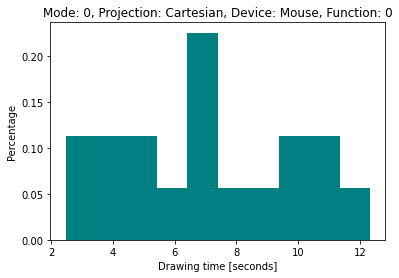

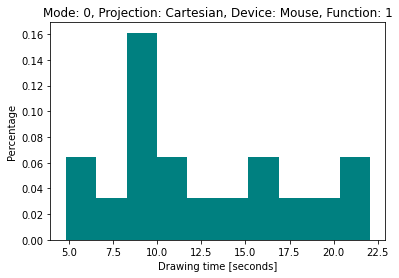

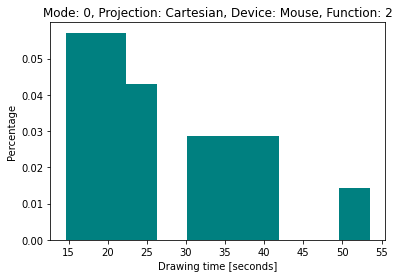

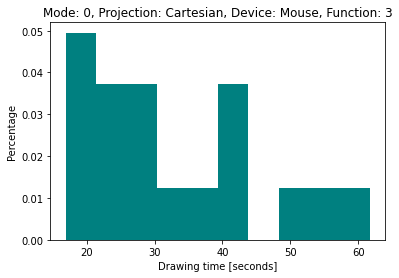

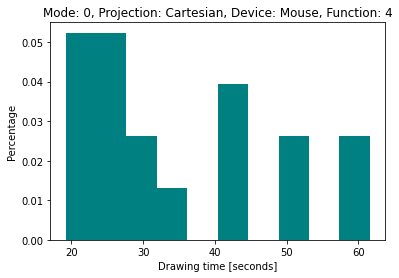

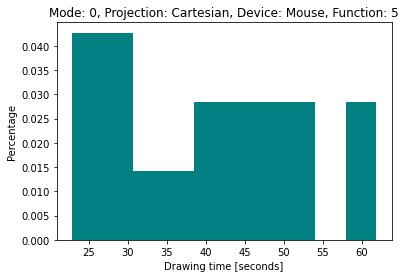

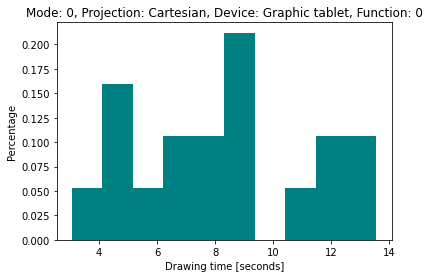

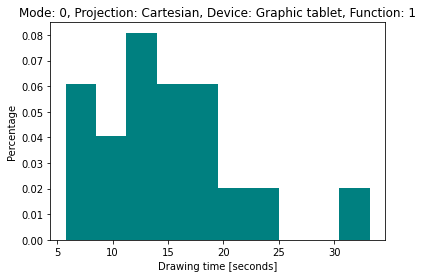

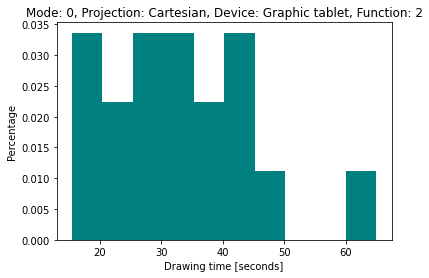

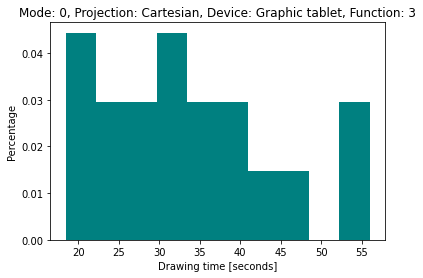

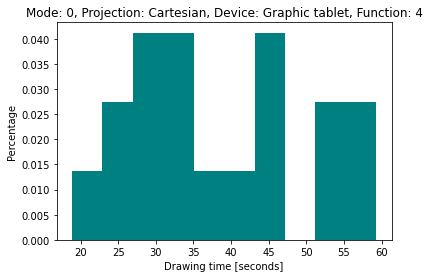

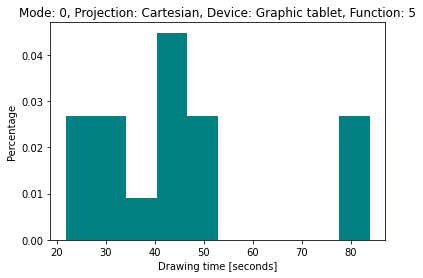

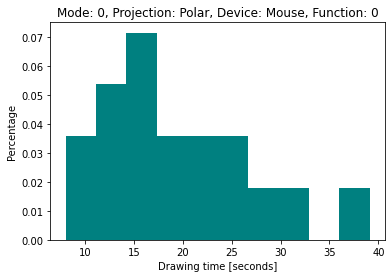

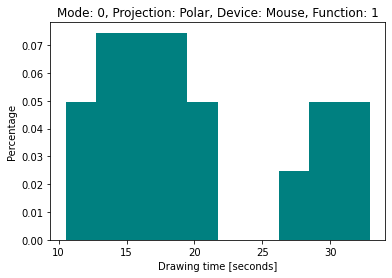

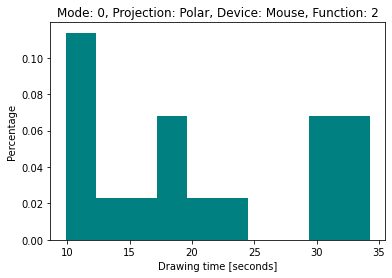

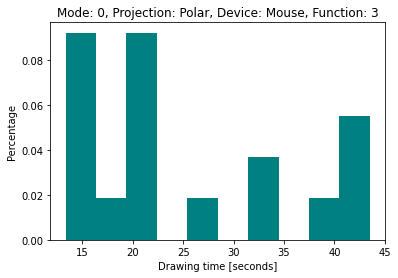

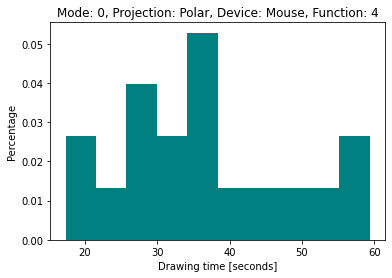

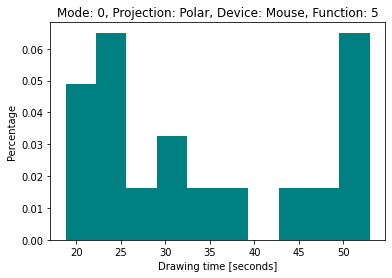

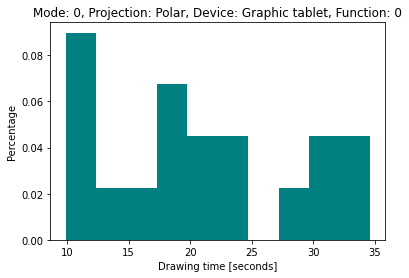

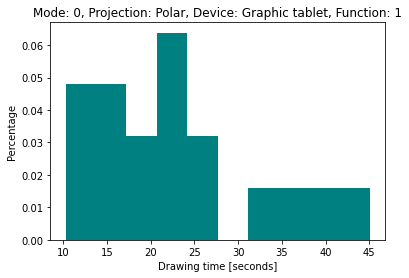

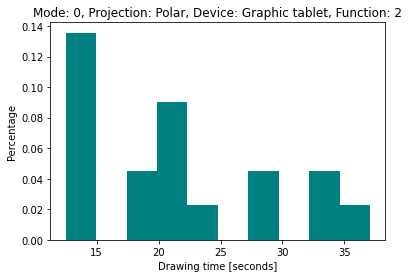

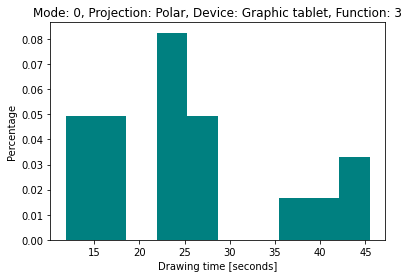

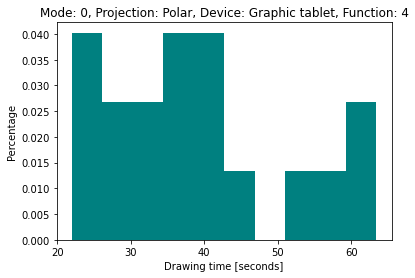

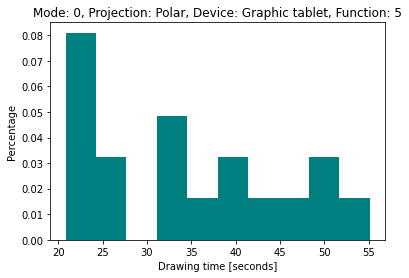

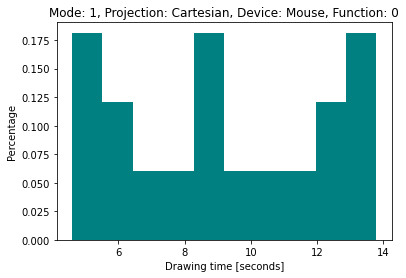

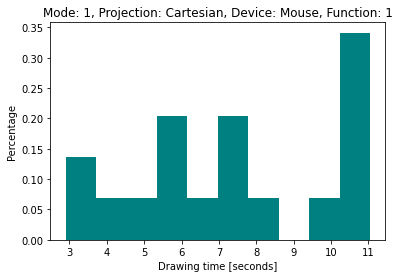

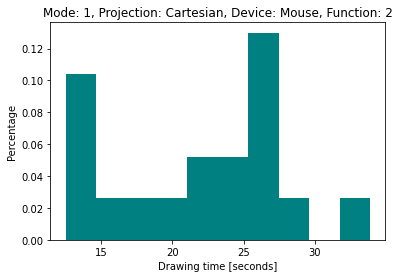

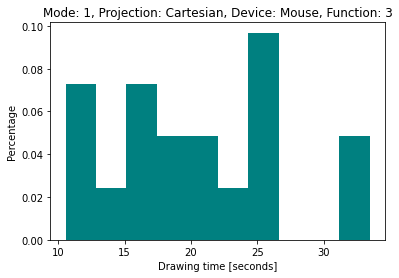

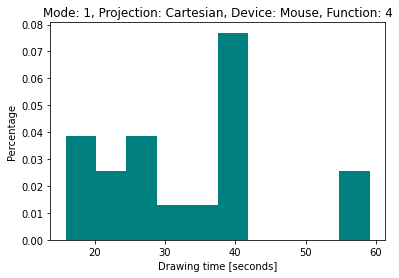

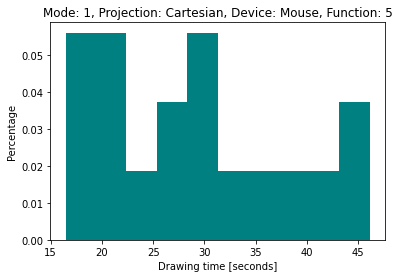

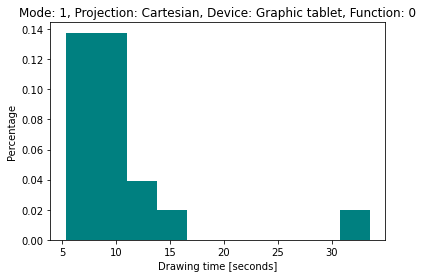

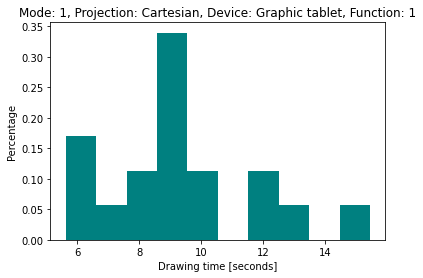

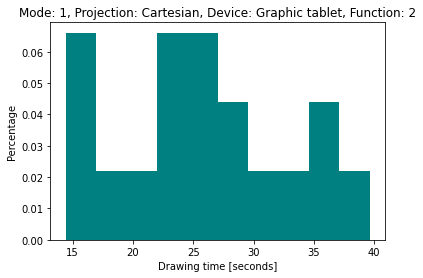

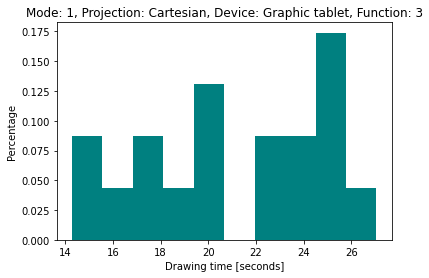

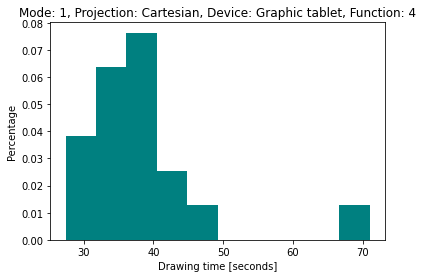

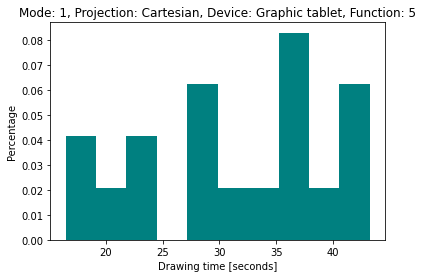

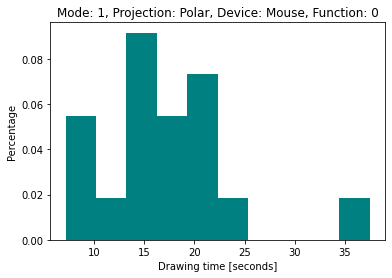

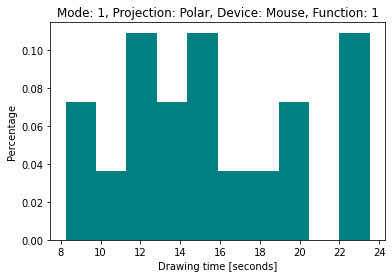

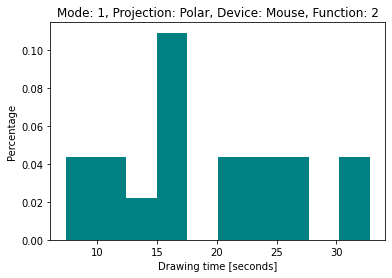

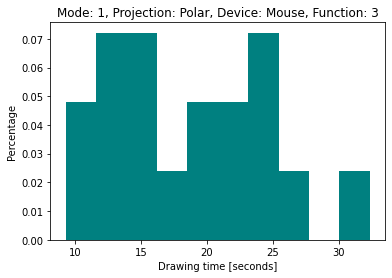

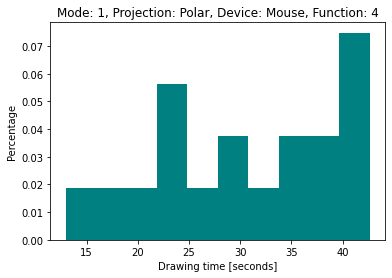

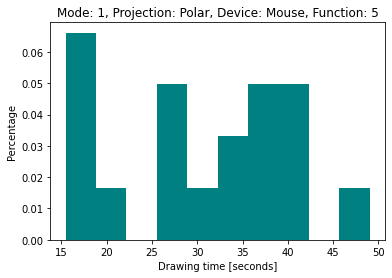

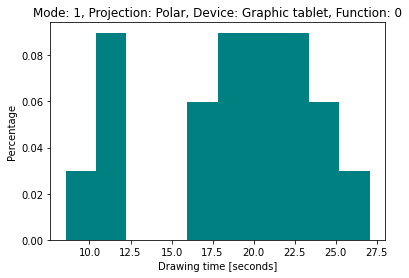

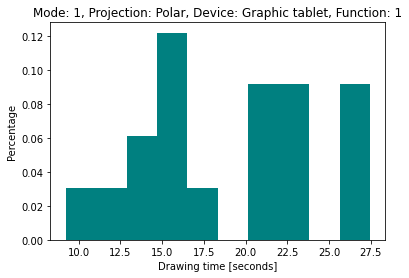

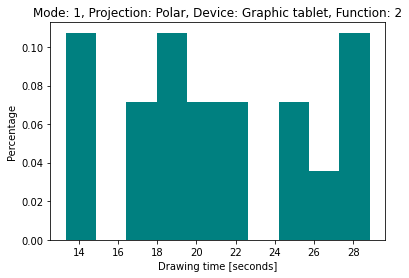

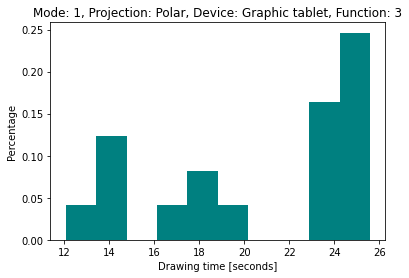

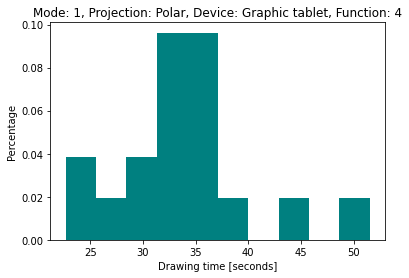

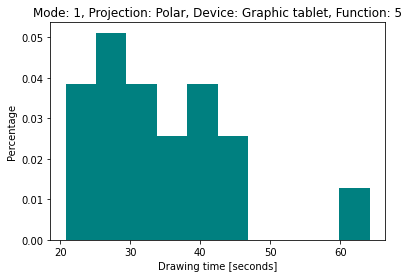

In [4]:
def getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data=df):
        # filter out by projection, Cartesian or Polar
    drawingTimes = data[data['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    drawingTimes = drawingTimes['Drawing time'].values
    
    return drawingTimes

projection = "Polar"
funcId = 0
device = "Mouse"
experimentMode = 0

for experimentMode in TEST_MODES:
    for projection in PROJECTIONS:
        for device in DEVICES:
            for funcId in FUNC_IDS:
                dts = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode)

                plt.figure()
                plt.hist(dts, density=True, color="teal")
                plt.title(
                    "Mode: %s, Projection: %s, Device: %s, Function: %s"
                     % (experimentMode, projection, device, funcId)
                )
                plt.ylabel("Percentage")
                plt.xlabel("Drawing time [seconds]")
                plt.show()



# Average drawing time for each curve on each input device

In [5]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0, data=df):
    drawingTimes = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
    
    avg = np.median(drawingTimes)
    
    return avg

def getAvgsByFilter(projections, funcIds, devices, experimentModes, data=df):
    times = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode, data)
                    times.append(avg)
    return times

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [6]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in devices:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, 50])
            plt.xlim([0, 31])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            plt.show()

## Test plots

In [7]:
# plotForExperiment([0, 1])

# Linear regression

In [8]:
def getDataForRegression(projections, experimentModes, device):
    iods = getIodsAsArray(projections, experimentModes)
    x = [[iod] for iod in iods]

    y = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    return x, y

def getRegressionModel(projections, experimentModes, device):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    plotDataAndReg(reg, x, y, "Linear regression for %s, %s" %(projections, device))

    return reg

def plotDataAndReg(reg, x, y, title):
    plt.figure()
    plt.scatter(x, y, label="Experiment data", color="crimson")

    predictX = np.linspace(1, 30, 10)
    predictY = reg.predict([[x] for x in predictX])
    plt.plot(predictX, predictY, color="black", label="Linear regression")
    
    plt.ylabel("Drawing time (seconds)")
    plt.xlabel("Index of difficulty")
    plt.ylim([0, 50])
    plt.xlim([0, 31])
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

def validateRegressionModel(reg, projections, experimentModes, device):  
    x, y = getDataForRegression(projections, experimentModes, device)
    plotDataAndReg(reg, x, y, "Validating linear regression for %s, %s" %(projections, device))

    
    print("R^2 =", reg.score(x, y))


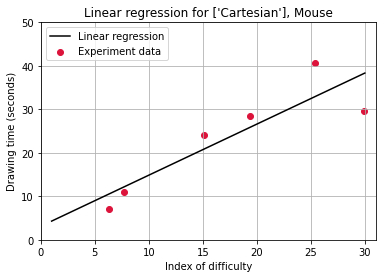

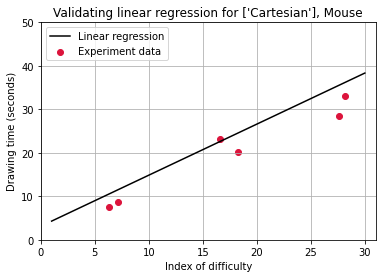

R^2 = 0.8217666277004275


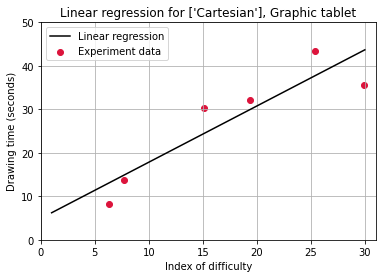

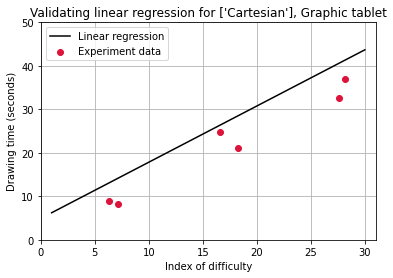

R^2 = 0.7253819471087515


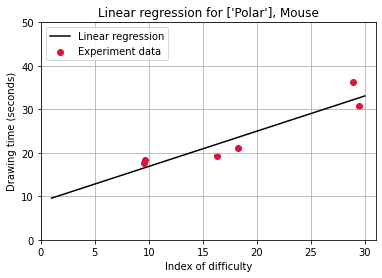

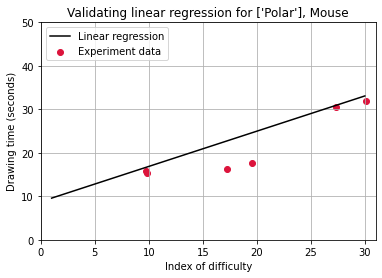

R^2 = 0.6833632348383836


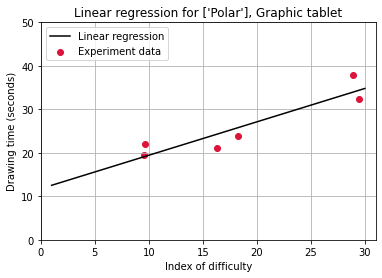

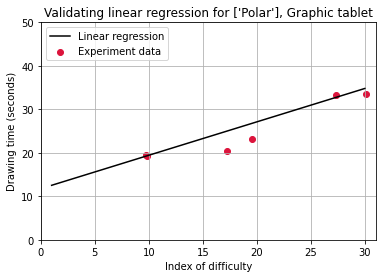

R^2 = 0.8418136040904846


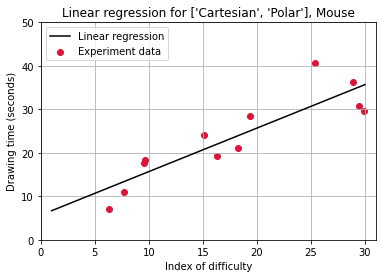

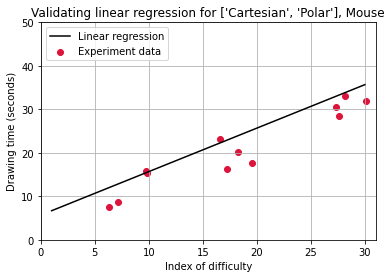

R^2 = 0.7630764235353831


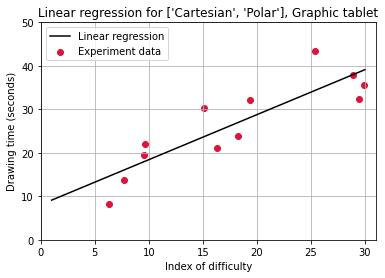

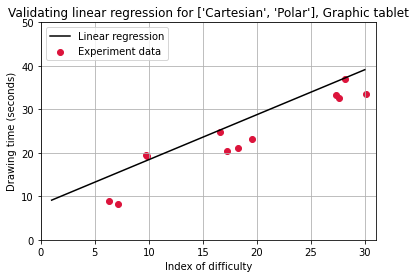

R^2 = 0.7527125407098657


In [9]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        reg = getRegressionModel(projections, [0], device)
        validateRegressionModel(reg, projections, [1], device)


# Participant data

Number of participants: 9
Average participant age: 23.111

 ::::
Number of left handed participants: 1
Percentage of left handed participants 0.111 %

 ::::
Number of expert graphic tablet participants: 2
Percentage of expert graphic tablet participants 0.222 %

 ::::
Average drawing times


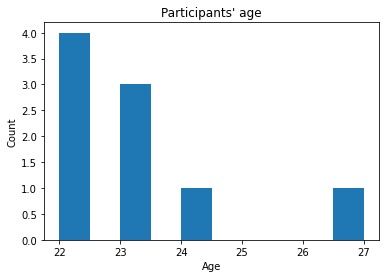

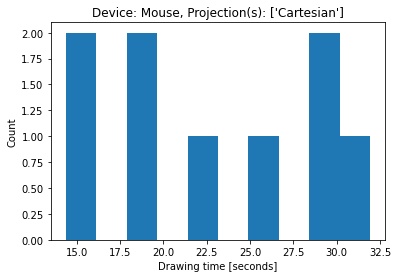

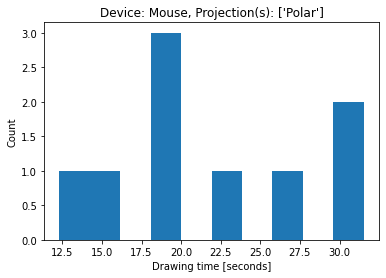

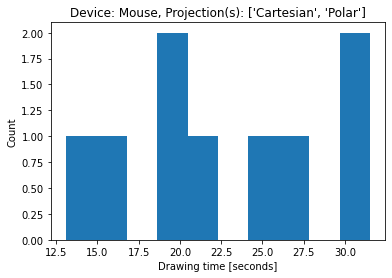

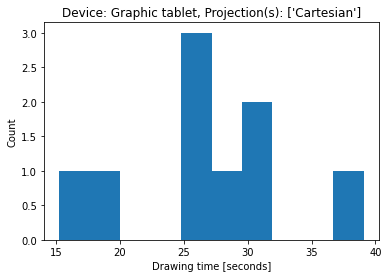

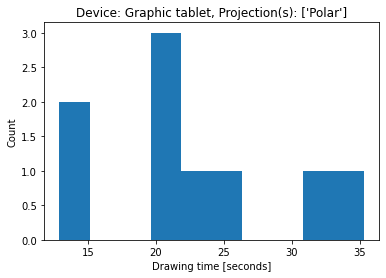

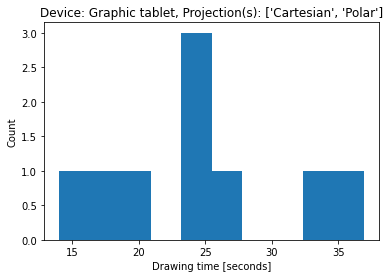

In [35]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
leftHanded = 0
hasExpWTablet = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    leftHanded += row['Is Left handed'].values[0]
    hasExpWTablet += row['Experienced Graphic Tablet User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages)
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))

print("\n ::::")
print("Number of left handed participants:", leftHanded)
print("Percentage of left handed participants", round(leftHanded * 1.0 / len(participants), 3), '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3), '%'
    )


print("\n ::::")
print("Average drawing times")
# Average drawing time per user
for device in DEVICES:
    for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
        pltData = []
        for participant in participants:
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes = getAvgsByFilter(projections, [funcId], [device], [experimentMode], drawingTimes)
                    dts.append(drawingTimes)
            # print(participant, device, projections, np.mean(dts))
            pltData.append(np.median(dts))
        # print()
        plt.figure()
        plt.hist(pltData)
        plt.title("Device: %s, Projection(s): %s" %(device, projections))
        plt.ylabel("Count")
        plt.xlabel("Drawing time [seconds]")
        plt.show()
            


## Error approximation

In [81]:
for device in DEVICES:
    for i in range(len(participants)):
        participant = participants[i]
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        

ivana_bacac Polar (2) 0 0 Mouse 0.029736272738095242
ivana_bacac Cartesian (0) 0 2 Mouse 0.041331875866114566
ivana_bacac Cartesian (0) 0 4 Mouse 0.0411904611627907
ivana_bacac Cartesian (0) 0 3 Mouse 0.05503490423151126
ivana_bacac Cartesian (0) 0 3 Mouse 0.052957472821782176
ivana_bacac Polar (2) 0 3 Mouse 0.025285719952830188
ivana_bacac Polar (2) 0 1 Mouse 0.020777745765822787
ivana_bacac Cartesian (0) 0 0 Mouse 0.011895298476608186
ivana_bacac Polar (2) 0 4 Mouse 0.06085773402647976
ivana_bacac Cartesian (0) 0 5 Mouse 0.06167647022116904
ivana_bacac Cartesian (0) 0 1 Mouse 0.017948971721311473
ivana_bacac Cartesian (0) 0 0 Mouse 0.010195970122807015
ivana_bacac Polar (2) 0 4 Mouse 0.046328852069169965
ivana_bacac Cartesian (0) 0 1 Mouse 0.015493687853773584
ivana_bacac Polar (2) 0 1 Mouse 0.02190049253502335
ivana_bacac Polar (2) 0 5 Mouse 0.03425129798028312
ivana_bacac Polar (2) 0 2 Mouse 0.028042738702723145
ivana_bacac Cartesian (0) 0 2 Mouse 0.03924632249672346
ivana_bacac Ca

Stjepan.Obad Polar (3) 1 1 Mouse 0.01422449438534279
Stjepan.Obad Cartesian (1) 1 0 Mouse 0.011787352344479004
Stjepan.Obad Cartesian (1) 1 1 Mouse 0.007948224849544073
Stjepan.Obad Polar (3) 1 4 Mouse 0.03824461424682395
Stjepan.Obad Polar (3) 1 3 Mouse 0.025605348034997134
Stjepan.Obad Cartesian (1) 1 4 Mouse 0.05339363881254404
Stjepan.Obad Cartesian (1) 1 1 Mouse 0.006827587403394255
Stjepan.Obad Polar (3) 1 2 Mouse 0.01775752472987872
Stjepan.Obad Polar (3) 1 0 Mouse 0.018110809373194686
Stjepan.Obad Cartesian (1) 1 3 Mouse 0.021942346242165244
Stjepan.Obad Polar (3) 1 2 Mouse 0.018323179670079633
Stjepan.Obad Cartesian (1) 1 2 Mouse 0.04245705016061085
Stjepan.Obad Polar (3) 1 0 Mouse 0.018616277330760097
Stjepan.Obad Cartesian (1) 1 3 Mouse 0.024559194933035714
Stjepan.Obad Cartesian (1) 1 0 Mouse 0.009368686721260816
Vito Medved Polar (2) 0 0 Mouse 0.027538743404494383
Vito Medved Polar (2) 0 2 Mouse 0.027462579639130437
Vito Medved Polar (2) 0 5 Mouse 0.039069159430118613
Vito

Karolina Skunca Polar (2) 0 3 Mouse 0.014131324375624374
Karolina Skunca Cartesian (0) 0 5 Mouse 0.05149660624524956
Karolina Skunca Polar (2) 0 1 Mouse 0.007943733553208997
Karolina Skunca Cartesian (0) 0 1 Mouse 0.010995570495461422
Karolina Skunca Cartesian (0) 0 4 Mouse 0.026182671717391307
Karolina Skunca Cartesian (1) 1 2 Mouse 0.042627341131592424
Karolina Skunca Polar (3) 1 1 Mouse 0.012509879238018311
Karolina Skunca Cartesian (1) 1 4 Mouse 0.034047823048172755
Karolina Skunca Polar (3) 1 3 Mouse 0.02734260144785276
Karolina Skunca Polar (3) 1 4 Mouse 0.031730509468641116
Karolina Skunca Polar (3) 1 5 Mouse 0.028654738379032263
Karolina Skunca Cartesian (1) 1 2 Mouse 0.040393593998059196
Karolina Skunca Cartesian (1) 1 0 Mouse 0.008409503498614959
Karolina Skunca Polar (3) 1 0 Mouse 0.010855174138715179
Karolina Skunca Cartesian (1) 1 3 Mouse 0.017524446433084432
Karolina Skunca Polar (3) 1 0 Mouse 0.009883152851966875
Karolina Skunca Cartesian (1) 1 1 Mouse 0.0085314799958275

RaulAntonio Šanko Polar (3) 1 0 Graphic tablet 0.017673436415636044
RaulAntonio Šanko Cartesian (1) 1 4 Graphic tablet 0.048705380710018384
RaulAntonio Šanko Polar (3) 1 3 Graphic tablet 0.04098179063227954
RaulAntonio Šanko Polar (3) 1 5 Graphic tablet 0.04137949274754255
RaulAntonio Šanko Cartesian (1) 1 3 Graphic tablet 0.02657889848969289
RaulAntonio Šanko Polar (3) 1 1 Graphic tablet 0.015656580368772068
RaulAntonio Šanko Cartesian (1) 1 5 Graphic tablet 0.03026189437037037
RaulAntonio Šanko Cartesian (1) 1 1 Graphic tablet 0.00978848578926097
RaulAntonio Šanko Polar (3) 1 2 Graphic tablet 0.02965468553468847
RaulAntonio Šanko Polar (3) 1 2 Graphic tablet 0.025124879582553352
RaulAntonio Šanko Polar (3) 1 1 Graphic tablet 0.016810709081718618
RaulAntonio Šanko Cartesian (1) 1 0 Graphic tablet 0.01875734427919708
RaulAntonio Šanko Polar (3) 1 4 Graphic tablet 0.04605754141865079
lenanovak Cartesian (0) 0 0 Graphic tablet 0.00921019580425056
lenanovak Polar (2) 0 0 Graphic tablet 0.

Vito Medved Cartesian (1) 1 4 Graphic tablet 0.06223141764423078
Vito Medved Cartesian (1) 1 4 Graphic tablet 0.058979958399149456
Vito Medved Polar (3) 1 0 Graphic tablet 0.009958245934545454
Vito Medved Cartesian (1) 1 0 Graphic tablet 0.01991345581081081
Vito Medved Polar (3) 1 4 Graphic tablet 0.06149920134215501
marin_legenda Polar (2) 0 3 Graphic tablet 0.03194526392989614
marin_legenda Polar (2) 0 0 Graphic tablet 0.024429807158878502
marin_legenda Cartesian (0) 0 1 Graphic tablet 0.029751752722323048
marin_legenda Polar (2) 0 2 Graphic tablet 0.03467879121750433
marin_legenda Polar (2) 0 5 Graphic tablet 0.05989532196137826
marin_legenda Cartesian (0) 0 3 Graphic tablet 0.05824660194504476
marin_legenda Polar (2) 0 0 Graphic tablet 0.021746999717138102
marin_legenda Cartesian (0) 0 3 Graphic tablet 0.06135308738211381
marin_legenda Cartesian (0) 0 0 Graphic tablet 0.010290112234649122
marin_legenda Cartesian (0) 0 4 Graphic tablet 0.05368918421644188
marin_legenda Polar (2) 0 2

ivabracko Polar (2) 0 3 Graphic tablet 0.022869405074626866
ivabracko Cartesian (0) 0 1 Graphic tablet 0.013841281515151516
ivabracko Polar (2) 0 4 Graphic tablet 0.03876380637898687
ivabracko Cartesian (0) 0 4 Graphic tablet 0.029858061258660508
ivabracko Polar (2) 0 0 Graphic tablet 0.012645352030978071
ivabracko Polar (2) 0 3 Graphic tablet 0.018545389329407917
ivabracko Polar (2) 0 2 Graphic tablet 0.022296414597565765
ivabracko Polar (2) 0 0 Graphic tablet 0.01946950502947481
ivabracko Cartesian (0) 0 1 Graphic tablet 0.01315896482074264
ivabracko Polar (2) 0 5 Graphic tablet 0.02071867876340138
ivabracko Polar (2) 0 1 Graphic tablet 0.024265873056822897
ivabracko Cartesian (0) 0 2 Graphic tablet 0.03938761185245457
ivabracko Cartesian (0) 0 3 Graphic tablet 0.05014453575380359
ivabracko Cartesian (0) 0 0 Graphic tablet 0.008054267372370938
ivabracko Polar (2) 0 5 Graphic tablet 0.03655700536408396
ivabracko Cartesian (0) 0 2 Graphic tablet 0.03578662516017742
ivabracko Cartesian 